# Rotating Gaussian bump

Aiming to replicate Figure 4 from [aceitunoResonancesInducedSpiking2020](http://arxiv.org/abs/2006.08537) using Bindsnet simulation

In [1]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
import bindsnet.analysis.plotting
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.rc('figure', figsize=(12.0, 8.0))

In [2]:
def wrap_half_period(x: torch.Tensor, period: int):
	return (x + period//2) % period - period//2

def circ_norm_unnormalised(x: torch.Tensor, mean: torch.Tensor, stdev: float, wrap: int):
	return torch.exp(-wrap_half_period(x - mean, wrap)**2 / 2/stdev**2)

def get_rotating_gaussian(time: int, neurons: int, bump_speed: int, stdev: float):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(neurons))
	return circ_norm_unnormalised(x, (t*bump_speed) % neurons, stdev, neurons)

def convert_to_spikes(x: torch.Tensor, noise_ratio: float=0.0):
	return torch.rand_like(x) < (noise_ratio*torch.rand_like(x) + (1.0-noise_ratio)*(x / x.max()))

def sum_by_index(data: torch.Tensor, indices: torch.Tensor):
	return torch.zeros(indices.max().numpy()+1).index_add(0,indices.flatten(),data.flatten().float())

def roll_tensor_rows(tensor, roll_amounts):
	tensor_rolled = tensor[:, [*range(tensor.shape[1]),*range(tensor.shape[1]-1)]].clone()
	stride_0, stride_1 = tensor_rolled.stride()
	num_cols = tensor.shape[1]
	result = torch.as_strided(tensor_rolled, (*tensor.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[torch.arange(tensor.shape[0]), (num_cols-roll_amounts) % num_cols]

def get_time_periodic_profile(data: torch.Tensor, bump_speed: int):
	'''
	Return the average periodic spiking profile for the network (shifted so the centre angle is in the middle)

	:param data: Spiking output of the network [time*neurons]
	:param bump_speed: How many neurons the neural activity moves per timestep
	'''
	neurons = data.shape[1]
	shifts = -torch.arange(neurons) // bump_speed
	period = neurons // bump_speed
	return torch.roll(torch.stack(torch.split(roll_tensor_rows(data.T, shifts), period, dim=1)).sum(dim=0).sum(dim=0), period//2)

def get_weight_periodic_profile(weights: torch.Tensor):
	'''
	Return the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.mean(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0), neurons//2)

Create the input for the network

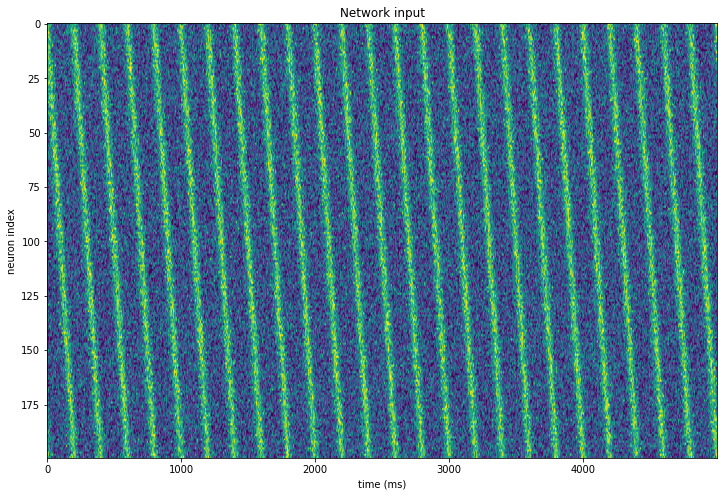

In [3]:
time = 5000
num_neurons = 200
bump_speed = 1
period = num_neurons // bump_speed
input_noise_ratio = 0.5

input_voltage = get_rotating_gaussian(time, num_neurons, bump_speed, num_neurons//10)
input_spikes = convert_to_spikes(input_voltage, input_noise_ratio)

plt.imshow(input_spikes.T)
plt.axis('auto')
plt.title('Network input')
plt.ylabel('neuron index')
plt.xlabel('time (ms)')
plt.show()

Create the network of LIF neurons with homeostatic+STDP plasticity. Weights are constrained to be nonnegative.

In [4]:
def set_learning_rates(connection, nu, gamma):
	connection.update_rule.nu = torch.Tensor([nu,nu])
	connection.update_rule.gamma = gamma

network = Network()

# Create and add input, output layers.
lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

network.add_layer(layer=lif_layer, name='LIF')

initial_weights = 0.1 * (torch.rand((lif_layer.n,lif_layer.n)))
initial_weights_copy = initial_weights.clone()
recurrent_connection = Connection(
    source=lif_layer,
    target=lif_layer,
	update_rule = HomeostaticSTDP,
	nu=0,
	gamma = 0,
	wmin=0,
    w=initial_weights,
)
network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')

# Create and add monitors for spikes and voltages
monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r'), time=time)
network.add_monitor(monitor=monitor, name='LIF_monitor')

# Simulate network on input data - need input to be strong enough to cause spiking
# run the network without learning for 1 s (before), then with learning for 3 s, then without learning for another second (after)
# we then compare the results before and after learning
input_weight = 4
network.run(inputs={'LIF': input_weight*input_spikes[:1000,:]}, time=1000, progress_bar=True)
set_learning_rates(recurrent_connection, 1e-2, 1e-4)
network.run(inputs={'LIF': input_weight*input_spikes[1000:-1000,:]}, time=time-2000, progress_bar=True)
set_learning_rates(recurrent_connection, 0, 0)
network.run(inputs={'LIF': input_weight*input_spikes[-1000:,:]}, time=1000, progress_bar=True)

# Retrieve data from monitors for analysis
spikes = monitor.get('s')
voltages = monitor.get('v')
rates = monitor.get('r')

spikes_before = spikes[:1000]
spikes_after = spikes[-1000:]

Network spiking - it matches the input signal - the noise-induced spiking seems to have decreased somewhat after learning.

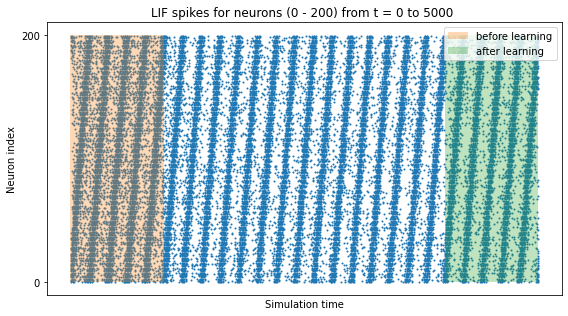

In [5]:
bindsnet.analysis.plotting.plot_spikes({"LIF": spikes})
plt.fill_between((0,1000), 0, num_neurons, alpha=0.3, label='before learning')
plt.fill_between((time-1000,time), 0, num_neurons, alpha=0.3, label='after learning')
plt.legend()
plt.show()

Replicating Figure 4 (top left):
The network activity is slightly less noisy after learning

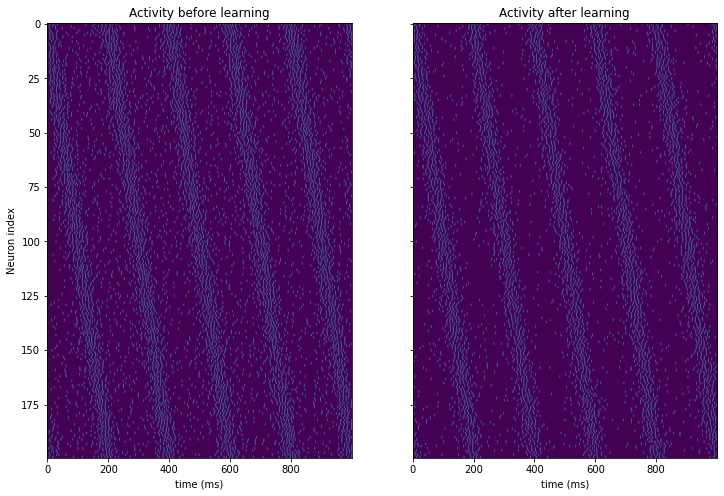

In [6]:
fig, axs = plt.subplots(1,2, sharey=True)
img1 = axs[0].imshow(spikes_before.squeeze().T, aspect='auto')
img2 = axs[1].imshow(spikes_after.squeeze().T, aspect='auto')
axs[0].set_title('Activity before learning')
axs[1].set_title('Activity after learning')
axs[0].set_ylabel('Neuron index')
axs[0].set_xlabel('time (ms)')
axs[1].set_xlabel('time (ms)')

plt.show()

Replicating Figure 4 (top right):
Centring the activity of each neuron on its preferred firing time and averaging over all neurons gives the following neuron activity profiles. The profile after learning is shifted downwards, reducing noisy out-of-bump firing.

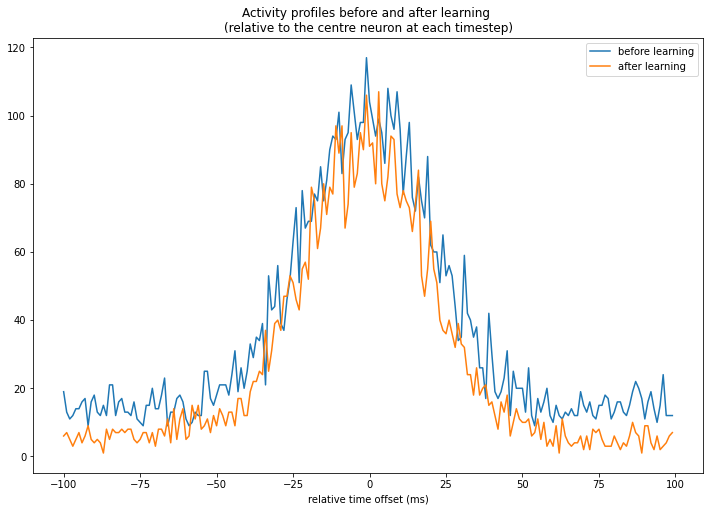

In [7]:
plt.plot(torch.arange(-period/2,period/2), get_time_periodic_profile(spikes_before.squeeze(), bump_speed), label='before learning')
plt.plot(torch.arange(-period/2,period/2), get_time_periodic_profile(spikes_after.squeeze(), bump_speed), label='after learning')
plt.legend()
plt.title('Activity profiles before and after learning \n(relative to the centre neuron at each timestep)')
plt.xlabel('relative time offset (ms)')
plt.show()

Replicating Figure 4 (bottom left):
The network weights after learning clearly show a biased 1D ring attractor - neurons that should fire next are excited by the current neuron, and neurons that just fired not excited.

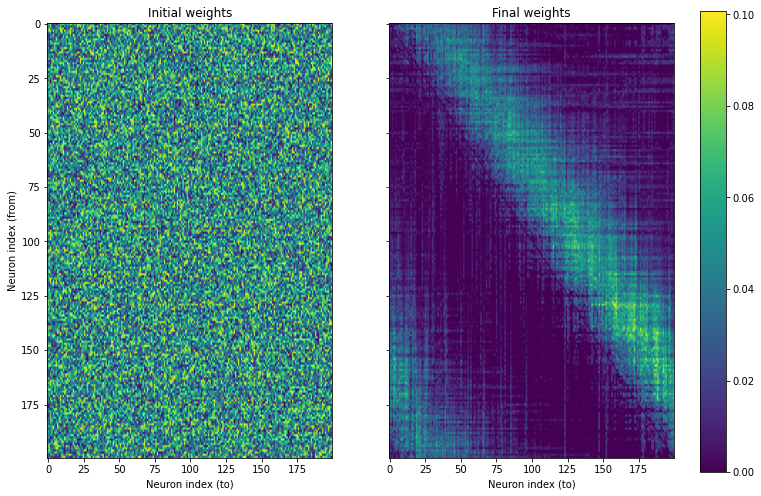

In [8]:
fig, axs = plt.subplots(1,2, sharey=True)
min_weight = min(initial_weights_copy.min().item(), recurrent_connection.w.min().item())
max_weight = max(initial_weights_copy.max().item(), recurrent_connection.w.max().item())

img1 = axs[0].imshow(initial_weights_copy, vmin=min_weight, vmax=max_weight, aspect='auto')
img2 = axs[1].imshow(recurrent_connection.w, vmin=min_weight, vmax=max_weight, aspect='auto')
axs[0].set_title('Initial weights')
axs[1].set_title('Final weights')
axs[0].set_ylabel('Neuron index (from)')
axs[0].set_xlabel('Neuron index (to)')
axs[1].set_xlabel('Neuron index (to)')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])
fig.colorbar(img2, cax=cbar_ax)
plt.show()

Replicating Figure 4 (bottom right):
The initial weights are random, but the profiles after learning (centred relative to each neuron and averaged) show a biased ring attractor shape (without inhibition)

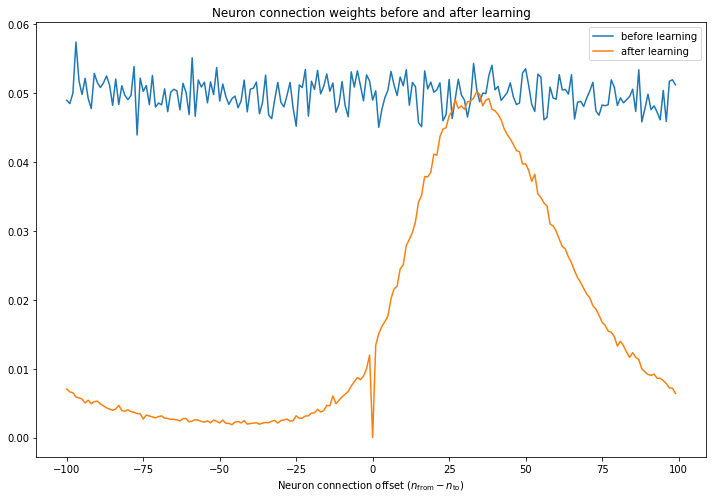

In [9]:
plt.plot(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(initial_weights_copy), label='before learning')
plt.plot(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(recurrent_connection.w), label='after learning')
plt.legend()
plt.title('Neuron connection weights before and after learning')
plt.xlabel(r'Neuron connection offset ($n_{\rm{from}} - n_{\rm{to}}$)')
plt.show()

Examining the neuron firing rate traces - the neurons converge to firing at ~25 Hz

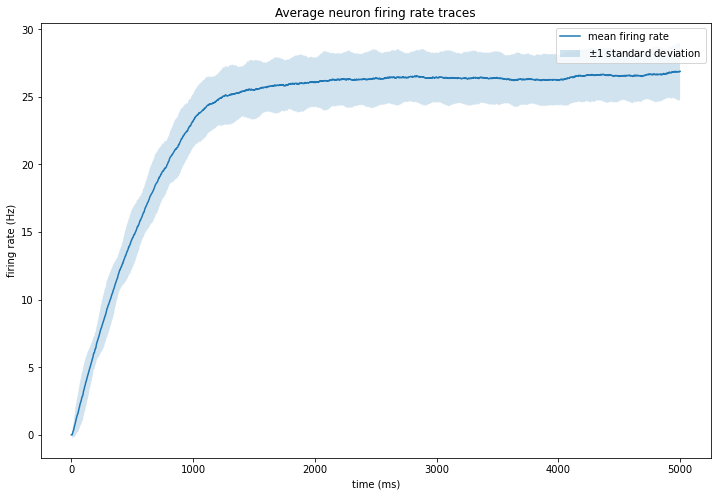

In [10]:
avg = rates.squeeze().mean(dim=1)
stdev = torch.sqrt(rates.squeeze().var(dim=1))
plt.plot(avg)
plt.fill_between(torch.arange(time), avg-stdev, avg+stdev, alpha=0.2)
plt.legend(['mean firing rate','$\\pm1$ standard deviation'])
plt.title('Average neuron firing rate traces')
plt.xlabel('time (ms)')
plt.ylabel('firing rate (Hz)')
plt.show()